## Palmer Penguins

**Dataset source:**  
Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081 

There are two `.csv` files: 
- `penguins_size` clean version of the dataset 
- `penguins_lter` original version  

Columns: 
- `species` penguin species out of three possibilities: Adélie, Gentoo, Chinstrap 
- `culmen_length_mm` culmen length measured in mm
- `culmen_depth_mm` culmen depth measured in mm
- `flipper_length_mm` flipper length measured in mm
- `body_mass_g` body mass in grams
- `island` island in the Palmer archipelago 
- `sex` penguin sex 

Goal: classify penguin species according to the features in the dataset

In [280]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 

df = pd.read_csv('penguins_lter.csv')
# Dropping columns 
df = df.drop(columns=['studyName', 'Sample Number', 'Region', 'Stage', 'Individual ID', 'Clutch Completion', 'Date Egg', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'])
# Renaming columns 
df = df.rename(columns={'Culmen Length (mm)':'CulmenLength', 'Culmen Depth (mm)': 'CulmenDepth', 'Flipper Length (mm)':'FlipperLength', 'Body Mass (g)': 'BodyMass'})
# Clean species name column
df.Species = df.Species.str.split(' ').str.get(0)
# Sex column has one entry as "."
df.loc[df.Sex == '.'] = np.nan
# There are 3 rows with null values
df.dropna(subset=['Species', 'CulmenLength'], inplace=True)

In [281]:
# Relation between Island and Penguin species
df.groupby('Island').Species.value_counts()
# In this study all penguins from the Torgensen island were Adélie penguins, so this feature will be dropped, as it will be too easy to detect Adélie penguins.

Island     Species  
Biscoe     Gentoo       122
           Adelie        44
Dream      Chinstrap     68
           Adelie        56
Torgersen  Adelie        51
Name: count, dtype: int64

### Selecting features

In [282]:
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
X = df[features]
y = df['Species']
# Encode y 
species_encoding = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
y = y.map(species_encoding)
# Train test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)

# Apply min-max normalization 
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)

X_train_norm = (X_train - X_train_min)/(X_train_max - X_train_min)
X_test_norm = (X_test - X_train_min)/(X_train_max - X_train_min)


In [283]:
# Correlation between features and the penguing species 
full_df = pd.concat([X, y], axis=1)
full_df.corr()['Species']
# Most important features (linearly correlated) flipper length and body mass

CulmenLength     0.732588
CulmenDepth     -0.743654
FlipperLength    0.853717
BodyMass         0.749896
Species          1.000000
Name: Species, dtype: float64

### Logistic Regression with no penalty

In [284]:
# Logistic regression 
from sklearn.linear_model import LogisticRegression

model0 = LogisticRegression(penalty=None)
model0.fit(X_train_norm, y_train)

# Calculating logits and accuracy manually
def lr_accuracy(X, y, weights, bias):
  logits = np.array(X @ weights.T + bias)
  predictions = logits.argmax(axis=1)
  accuracy = (predictions == y).sum()/len(y)
  return accuracy 

train_accuracy = lr_accuracy(X_train_norm, y_train, model0.coef_, model0.intercept_)
test_accuracy = lr_accuracy(X_test_norm, y_test, model0.coef_, model0.intercept_)
print(f"Train accuracy = {train_accuracy:.3f}, Test accuracy = {test_accuracy:.3f}")

Train accuracy = 1.000, Test accuracy = 0.988


### K-Nearest Neighbors

In [285]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

model1 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': list(range(1, 15, 2))}, cv=5)
model1.fit(X_train_norm, y_train)
k = model1.best_params_['n_neighbors']
# Retraining with the best performing number of neighbors 
model1 = KNeighborsClassifier(n_neighbors=k)
model1.fit(X_train_norm, y_train)

print(f"Train accuracy = {model1.score(X_train_norm, y_train):.3f}")
print(f"Test accuracy = {model1.score(X_test_norm, y_test):.3f}")

Train accuracy = 0.988
Test accuracy = 1.000


### Decision Tree

In [286]:
from sklearn.tree import DecisionTreeClassifier

model2 = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={'max_depth': list(range(1, 10)), 'ccp_alpha': np.logspace(-3, -1, 10)}, cv=5)
model2.fit(X_train_norm, y_train)
max_depth = model2.best_params_['max_depth']
ccp_alpha = model2.best_params_['ccp_alpha']
# Retraining with best max depth 
model2 = DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccp_alpha)
model2.fit(X_train_norm, y_train)

print(f"Train accuracy = {model2.score(X_train_norm, y_train):.3f}")
print(f"Test accuracy = {model2.score(X_test_norm, y_test):.3f}")

Train accuracy = 1.000
Test accuracy = 0.942


### Visualization with PCA

In [287]:
from sklearn.decomposition import PCA

# Normalizing entire dataset 
X_norm = (X - X.mean(axis=0))/X.std(axis=0)
pca = PCA(n_components=2)
pca.fit(X_norm)
X_reduced = pca.transform(X_norm)
df_comp = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])

# retrieving components
pc1 = pca.components_[0,:]
pc2 = pca.components_[1,:]
print(pc1) # uses all features 
print(pc2) # mostly related to the culmen length and depth 

[ 0.45567754 -0.39986671  0.57605664  0.54829129]
[0.59527516 0.79901439 0.00290432 0.0849415 ]


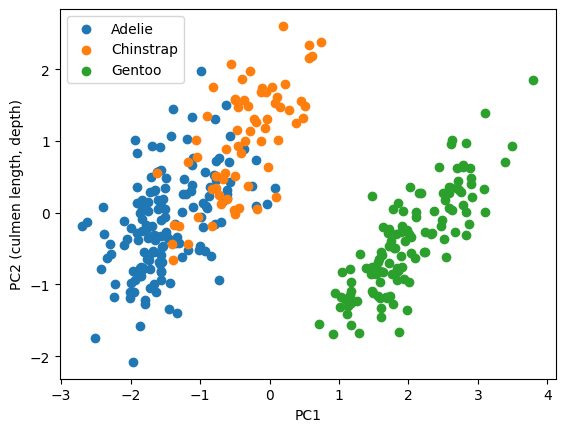

In [288]:
y.reset_index(inplace=True, drop=True)
plt.scatter(df_comp.PC1[y==0], df_comp.PC2[y==0], label='Adelie')
plt.scatter(df_comp.PC1[y==1], df_comp.PC2[y==1], label='Chinstrap')
plt.scatter(df_comp.PC1[y==2], df_comp.PC2[y==2], label='Gentoo')
plt.xlabel('PC1')
plt.ylabel('PC2 (culmen length, depth)')
plt.legend()

### Trying to make the model smaller

Looking at the mean values of the four features grouped by species, it is possible to see that: 
- Gentoo penguins tend to be the heaviest and also have longer flipper lengths compared to the two other species 
- Adelie have the smallest culmen length, and have similar culmen depth, slightly smaller flipper length and similar body mass compared with Chinstrap.

Therefore, `CulmenLength` and `FlipperLength` alone may be able to decently segregate the species.

In [289]:
df.groupby('Species')[features].mean()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
Species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Chinstrap,48.833824,18.420588,195.823529,3733.088235
Gentoo,47.529508,14.976230,217.188525,5077.663934


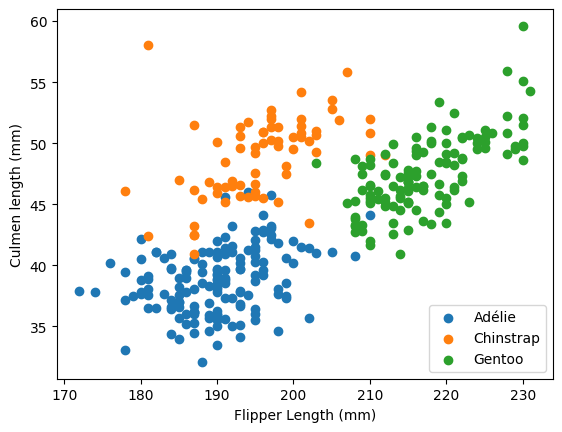

In [291]:
df.reset_index(inplace=True, drop=True)

plt.scatter(df.FlipperLength[y==0], df.CulmenLength[y==0], label='Adélie')
plt.scatter(df.FlipperLength[y==1], df.CulmenLength[y==1], label='Chinstrap')
plt.scatter(df.FlipperLength[y==2], df.CulmenLength[y==2], label='Gentoo')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Culmen length (mm)')
plt.legend()
plt.show()

### Retraining with only two features

In [300]:
features_small = ['CulmenLength', 'FlipperLength']
X_small = df[features_small]
y = df['Species'].map(species_encoding)

X_train, X_test, y_train, y_test = train_test_split(X_small, y, shuffle=True, random_state=42, test_size=0.25)

X_train_norm = (X_train-X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_test_norm = (X_test-X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))

In [301]:
model3 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': list(range(1, 15, 2))}, cv=5)
model3.fit(X_train_norm, y_train)
k = model3.best_params_['n_neighbors']
# Retraining with the best performing number of neighbors 
model3 = KNeighborsClassifier(n_neighbors=k)
model3.fit(X_train_norm, y_train)

print(f"Ideal number of neighbors: {k}")
print(f"Train accuracy: {model3.score(X_train_norm, y_train):.3f}")
print(f"Test accuracy: {model3.score(X_test_norm, y_test):.3f}")

Ideal number of neighbors: 3
Train accuracy: 0.973
Test accuracy: 0.942


### Plotting classified points 

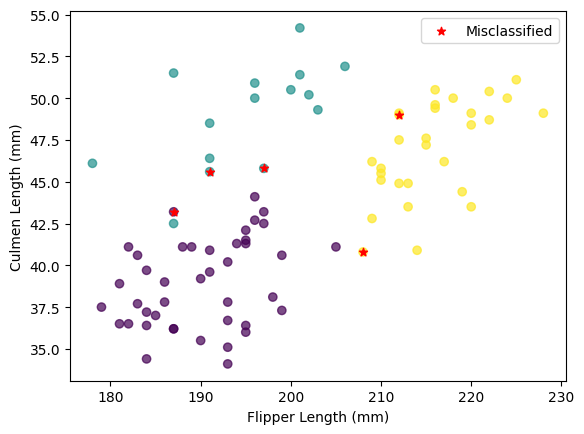

In [316]:
y_pred = model3.predict(X_test_norm)
# Plotting all predictions 
plt.scatter(X_test.FlipperLength, X_test.CulmenLength, c=y_pred, alpha=0.7)
# Overlapping with wrong predictions 
plt.scatter(X_test.FlipperLength[y_pred != y_test], X_test.CulmenLength[y_pred != y_test], c='red', marker='*', label='Misclassified')
plt.legend()
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Culmen Length (mm)')
plt.show()

### Concluding remarks
- When using all 4 numeric features, the KNN algorithm was found to be the best performing algorithm when compared with logistic regression and decision trees, reaching an accuracy of almost 100% on the test dataset. 
- The worst performing algorithm was the decision tree, which was able to achieve high accuracy in the training set, but poorer accuracy in the test set, which suggests overfitting. Pruning alleviates overfitting but the other two algorithms still perform better. 
- Using PCA with a number of components equal to 2, it is possible to easily segregate the Gentoo species from the other two, but there is still a high degree of overlap between Adélie and Chinstrap. 
- The Gentoo species is easily distinguished from Adélie and Chinstrap because, on average, it has a smaller culmen depth, longer flipper length and larger body mass. 
- On average, Adélie and Chinstrap have similar body mass and culmen depth. The feature that most distinguishes these two is the culmen length. 
- If culmen depth and body mass are removed, leaving only two features (culmen length and flipper length), naturally KNN classification accuracy ($k=3$) decreases. However, the accuracy on the test set with 2 features (0.942) is on par with that of the decision tree algorithm with 4 features. 
- By selecting the features that best distinguish each species it was possible to simplify the model while achieving good accuracy (minimizing information loss). 